# Machine Learning Model ANN with Grid Search

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense


warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [29]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

### Prepare data

In [30]:
x_train = pd.read_csv('./data_f1/cleaned_data.csv')
x_test = pd.read_csv('./data_f1/cleaned_data_2022.csv')

In [31]:
x_train = x_train[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]
x_test = x_test[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [32]:
x_train = x_train[x_train['active_constructor']==1]
x_train = x_train[x_train['active_driver']==1]

x_test = x_test[x_test['active_constructor']==1]
x_test = x_test[x_test['active_driver']==1]

In [33]:
sc  = StandardScaler()
le = LabelEncoder()

x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
x_train['constructor'] = le.fit_transform(x_train['constructor'])
x_train['driver'] = le.fit_transform(x_train['driver'])
x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
X_train = x_train.drop(['position','active_driver','active_constructor'],1)
y_train = x_train['position'].apply(lambda x: position_index(x))

x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
x_test['constructor'] = le.fit_transform(x_test['constructor'])
x_test['driver'] = le.fit_transform(x_test['driver'])
x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
X_test = x_test.drop(['position','active_driver','active_constructor'],1)
y_test = x_test['position'].apply(lambda x: position_index(x))

### Hyperparameter tuning with GridSearch

In [34]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(6,)))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    # opt = optimizers.Adamax(learning_rate=0.01)
    # model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [35]:
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", verbose=0)

In [36]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

In [37]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [38]:
# Fit the grid search object to the training data
grid_result = grid_search.fit(X_train, y_train)

In [39]:
# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)

Best hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'Nadam'}
Best score: 0.9200770321188765


In [40]:
# Re-train the model with the best hyperparameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

KerasClassifier(
	model=<function create_model at 0x000001E6B070E560>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Nadam
	loss=sparse_categorical_crossentropy
	metrics=None
	batch_size=20
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

In [41]:
y_pred = best_clf.predict(X_test)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 80


In [42]:
 # Test the model with the best hyperparameters on the testing data
accuracy = best_clf.score(X_test, y_test)
print("Testing accuracy:", accuracy)

Testing accuracy: 0.8181818181818182


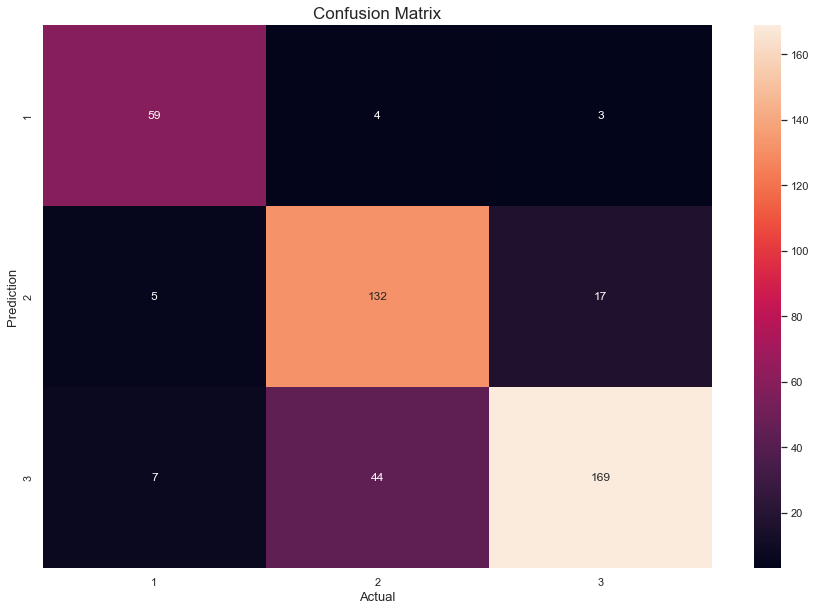

In [43]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()